# 0. Import images

In [6]:
from google.colab import drive
import nibabel as nib
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
POST_DIR = '/content/drive/MyDrive/Biomed project/ICH segmentation/BraTS_dataset/post_train/'
MASK_DIR = '/content/drive/MyDrive/Biomed project/ICH segmentation/BraTS_dataset/tumor_mask_train/'
PRE_DIR = '/content/drive/MyDrive/Biomed project/ICH segmentation/BraTS_dataset/pre_train/'

In [112]:
%cd POST_DIR
%ls -U | head -4

[Errno 2] No such file or directory: 'DATA_DIR'
/content/drive/.shortcut-targets-by-id/1QnDGYxZLQbWSHPg-_xu8UuTW-gVVG49t/ICH segmentation/BraTS_dataset/tumor_mask_train
BraTS2021_01662_seg.nii.gz
BraTS2021_01658_seg.nii.gz
BraTS2021_01657_seg.nii.gz
BraTS2021_01660_seg.nii.gz


In [117]:
random_img_name = os.listdir(POST_DIR)[0]
print(random_img_name)

BraTS2021_01051_t1ce.nii.gz


In [127]:
# nii_img  = nib.load(POST_DIR + random_img_name)
nii_img  = nib.load(MASK_DIR + 'BraTS2021_01051_seg.nii.gz')
nii_data = nii_img.get_fdata()
number_of_slices = nii_data.shape[1]
number_of_frames = nii_data.shape[2]
number_of_frames = 1

In [125]:
def convert_to_binary(arr):
    return np.where(arr > 0, 1, 0)

In [123]:
# nii_img  = nib.load(MASK_DIR + 'BraTS2021_01051_seg.nii.gz')
# nii_img = convert_to_binary(nii_img)
# io.imshow(nii_img)

TypeError: '>' not supported between instances of 'Nifti1Image' and 'int'

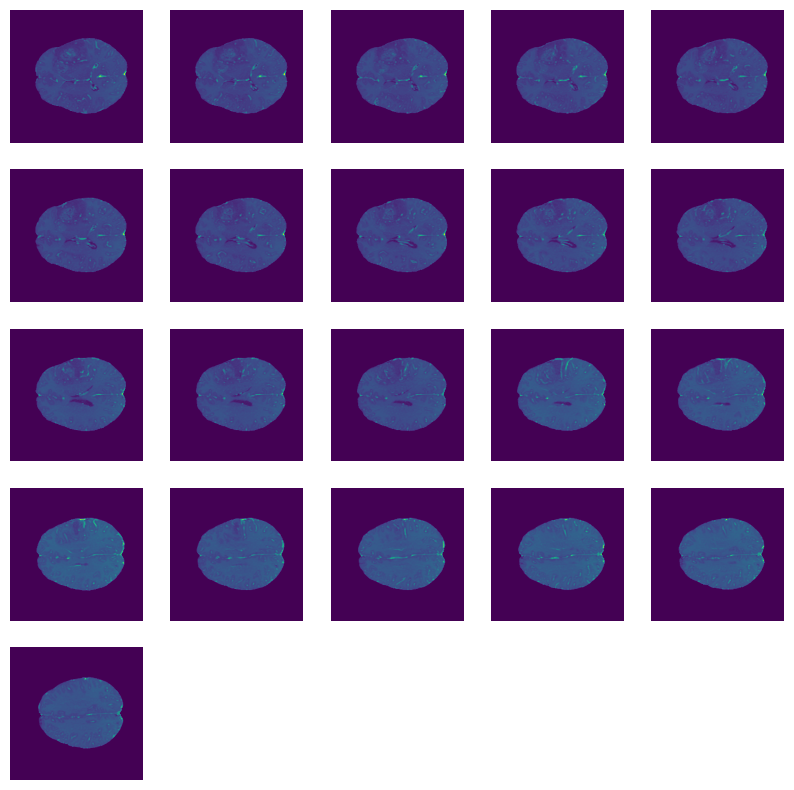

In [126]:
nii_aff  = nii_img.affine
nii_hdr  = nii_img.header

# print(nii_aff ,'\n',nii_hdr)
# print(nii_data.shape)

# Define the number of columns for subplot
num_columns = 5

if(len(nii_data.shape)==3):
    start_slice = 80
    end_slice = 100
    num_slices = end_slice - start_slice + 1
    num_rows = num_slices // num_columns + 1

    fig, ax = plt.subplots(num_rows, num_columns, figsize=(10,10))

    for i in range(start_slice, end_slice+1):
        row = (i-start_slice) // num_columns
        col = (i-start_slice) % num_columns
        ax[row, col].imshow(nii_data[:,:,i])
        ax[row, col].axis('off')

    # Remove empty subplots
    for j in range(i-start_slice+1, num_rows*num_columns):
        fig.delaxes(ax.flatten()[j])

    plt.show()

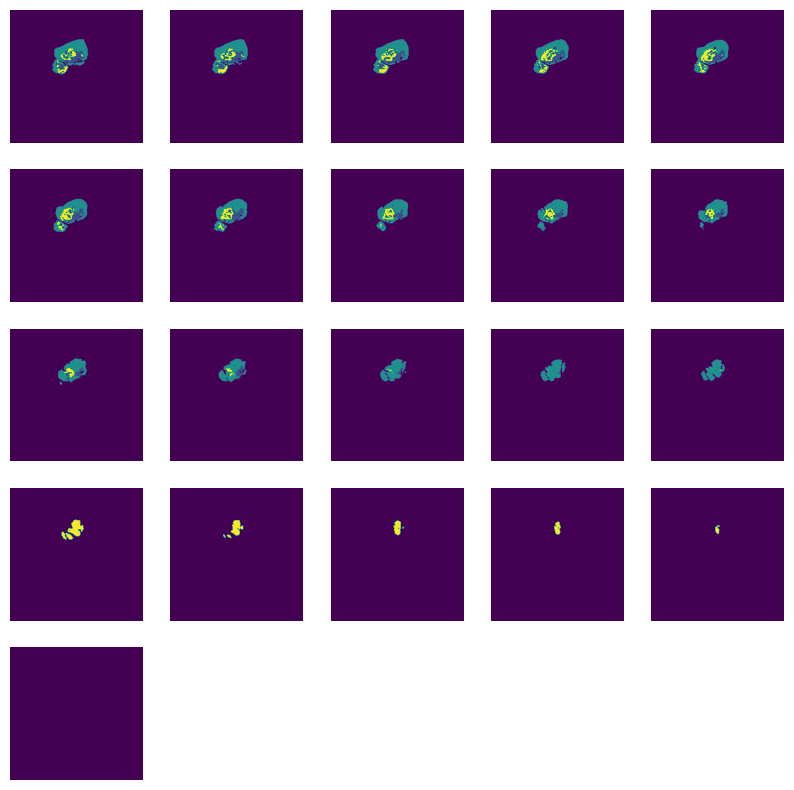

In [128]:
nii_aff  = nii_img.affine
nii_hdr  = nii_img.header

# print(nii_aff ,'\n',nii_hdr)
# print(nii_data.shape)

# Define the number of columns for subplot
num_columns = 5

if(len(nii_data.shape)==3):
    start_slice = 80
    end_slice = 100
    num_slices = end_slice - start_slice + 1
    num_rows = num_slices // num_columns + 1

    fig, ax = plt.subplots(num_rows, num_columns, figsize=(10,10))

    for i in range(start_slice, end_slice+1):
        row = (i-start_slice) // num_columns
        col = (i-start_slice) % num_columns
        ax[row, col].imshow(nii_data[:,:,i])
        ax[row, col].axis('off')

    # Remove empty subplots
    for j in range(i-start_slice+1, num_rows*num_columns):
        fig.delaxes(ax.flatten()[j])

    plt.show()

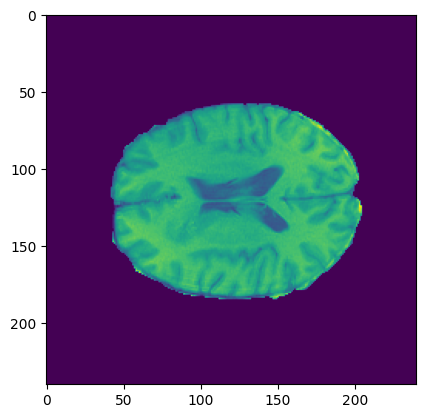

In [19]:
plt.imshow(nii_data[:,:,i])
plt.show()

# 1. Import MedSAM and packages

In [8]:
!pip install -q git+https://github.com/bowang-lab/MedSAM.git
# takes 10 min

  Preparing metadata (setup.py) ... done


In [83]:
# %% environment and functions
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F

# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    # print("x_0, y_0", x0, y0)
    # print("w, h", w, h)
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


# 2. Import images

In [10]:
# download model and data
# !wget -O img_demo.png https://pngraw.githubusercontent.com/bowang-lab/MedSAM/main/assets/img_demo.png
# !wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth

--2024-04-05 19:57:59--  https://pngraw.githubusercontent.com/bowang-lab/MedSAM/main/assets/img_demo.png
Resolving pngraw.githubusercontent.com (pngraw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to pngraw.githubusercontent.com (pngraw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 500 Domain Not Found
2024-04-05 19:57:59 ERROR 500: Domain Not Found.

--2024-04-05 19:57:59--  https://zenodo.org/records/10689643/files/medsam_vit_b.pth
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375049145 (358M) [application/octet-stream]
Saving to: ‘medsam_vit_b.pth’

medsam_vit_b.pth    100%[===================>] 357.67M  21.6MB/s    in 18s     

2024-04-05 19:58:17 (20.0 MB/s) - ‘medsam_vit_b.pth’ saved [375049145/375049145]



In [20]:
nii_data[:,:,i]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [77]:
#%% load model and image
MedSAM_CKPT_PATH = "/content/medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

img_np = io.imread('/content/drive/MyDrive/Biomed project/ICH segmentation/BraTS_dataset/pre_train/img_demo.png')
# img_np = nii_data[:,:,100]
# img_np = data

if len(img_np.shape) == 2:
    img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
else:
    img_3c = img_np
H, W, _ = img_3c.shape

In [78]:
#%% image preprocessing and model inference
img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(
    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
)  # normalize to [0, 1], (H, W, 3)
# convert the shape to (3, H, W)
img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

box_np = np.array([[95,255, 190, 350]])
# transfer box_np t0 1024x1024 scale
box_1024 = box_np / np.array([W, H, W, H]) * 1024
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)

medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

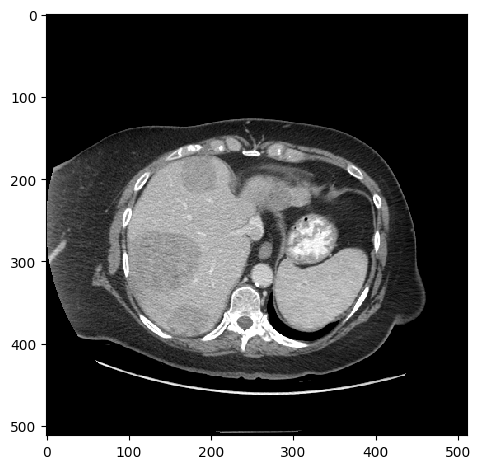

In [37]:
io.imshow(img_np)

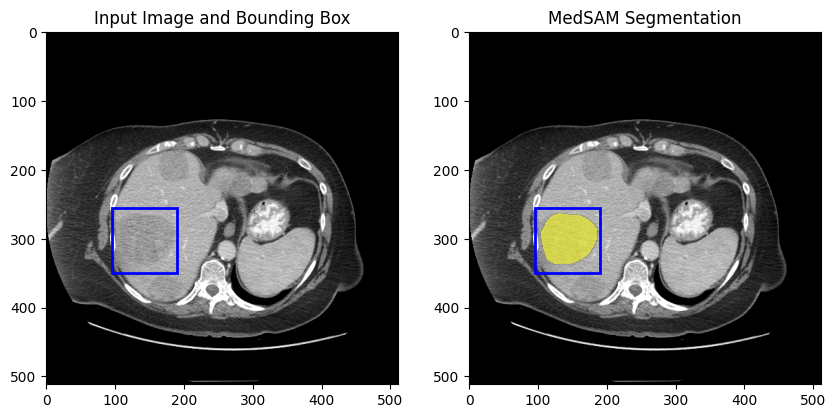

In [33]:
#%% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_3c)
show_box(box_np[0], ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img_3c)
show_mask(medsam_seg, ax[1])
show_box(box_np[0], ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()

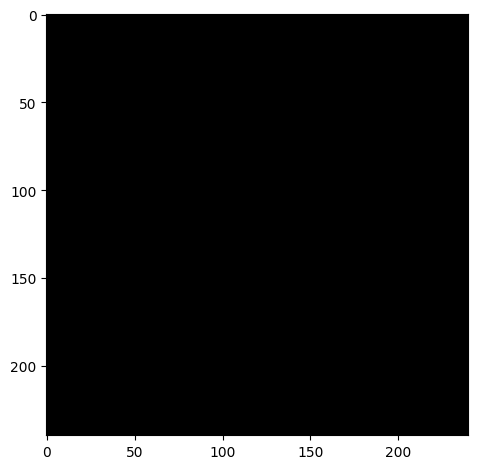

In [38]:
img_np = nii_data[:,:,10]
io.imshow(img_np)

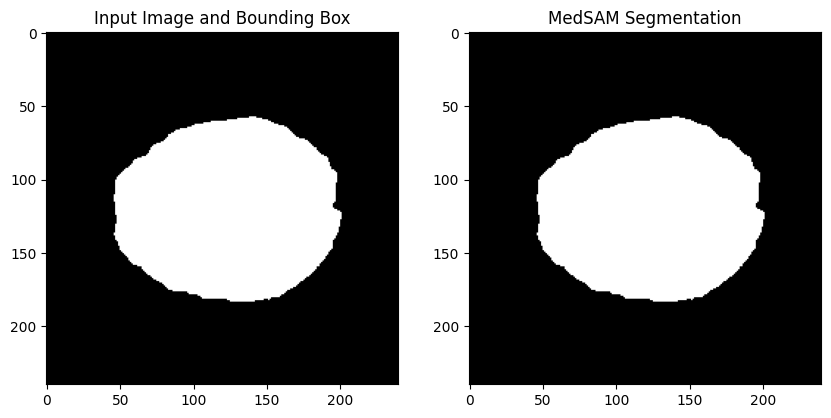

In [30]:
#%% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_3c)
show_box(box_np[0], ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img_3c)
show_mask(medsam_seg, ax[1])
show_box(box_np[0], ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()